In [21]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [22]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-01-16':'2017-05-24', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()

print(df_norm.shape)
df_norm.tail()

(89, 44)


,ARGT,COLO,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,GREK,INDA,KSA,MCHI,NORW,QAT,SPY,THD,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,-0.027677,-0.013065,-0.019476,0.003962,-0.001299,0.005805,0.003750,0.004426,-0.003956,-0.010492,-0.010566,-0.014109,0.002331,0.000388,-0.007160,0.001635,0.005616,0.006095,0.002668,-0.012328,0.002336,-0.000315,0.002418,-0.000487,-0.003677,0.000345,0.002980,0.001763,0.003200,-0.015525,0.000917,-0.163260,-0.015649,0.010582,-0.011728,0.004425,0.002100,-0.004991,0.000000,0.004028,0.001302,-0.015909,0.020735,-0.008590
2017-05-19,0.021687,0.021385,0.013951,0.012989,0.020297,0.053867,0.012374,0.004214,0.009577,0.021485,0.032465,0.020152,0.008837,0.018210,0.016226,0.010774,0.000859,0.016394,0.008172,0.015976,0.014564,0.011646,0.011027,0.029211,0.023985,0.013113,0.010611,0.012614,0.010151,0.025232,0.019856,0.067481,0.027009,0.006283,0.007495,0.001602,0.014482,0.016872,0.023069,0.006504,0.010663,0.031050,0.009286,0.014440
2017-05-22,-0.002653,-0.002991,-0.001632,0.007953,0.003570,-0.006572,0.005074,0.002289,0.007635,0.000273,0.004965,0.002290,0.007377,0.005708,0.001183,0.001938,-0.000858,0.005961,-0.000566,-0.002948,0.005742,0.004045,0.006816,0.011353,-0.005405,0.003747,0.000840,0.001449,0.000287,-0.003076,0.004493,-0.027746,0.003662,0.013527,-0.005269,0.000800,0.011458,0.003139,-0.011012,0.005077,0.002959,0.001991,-0.012651,-0.000712
2017-05-23,0.001330,-0.002000,-0.000468,-0.000322,0.010165,-0.007718,0.000000,-0.004949,0.002526,-0.001638,-0.018114,-0.009140,0.000000,-0.001514,0.007088,-0.001289,0.001289,-0.000348,0.001320,-0.001479,-0.003140,-0.000930,-0.002708,-0.000468,0.009964,-0.002375,-0.002518,-0.002893,-0.003157,0.004821,-0.004026,0.023831,0.021393,-0.005133,-0.014646,-0.003995,-0.006314,0.008494,-0.001061,0.002213,0.001796,0.012916,0.004077,-0.000712
2017-05-24,0.010628,0.004008,0.010984,0.003866,0.009057,-0.007407,-0.000918,0.005356,0.005726,0.004650,0.018029,-0.000865,0.001373,0.000758,0.001760,0.000968,0.004719,-0.002092,-0.001507,0.002468,-0.001718,0.004032,0.001358,0.010763,0.001196,0.001701,0.005890,0.004642,0.001152,0.019194,0.006287,0.010920,0.010879,-0.029928,0.003479,-0.000602,0.000561,0.001330,0.000000,0.002333,0.003714,0.004169,-0.003480,0.013542


In [23]:
# Define intervention date
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

In [24]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[:treatment_date].values
Y0_pre = donors[:treatment_date].values

In [25]:
# Find weights with restrictions as proposed by Abadie 

k = Y0_pre.shape[1]  # quantity of donors

# Objective function: minimize mean squared error (MSE)
def objective(w):
    Y_synth = w @ Y0_pre.T
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrictions:
# 1) sum of weights = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) weights >= 0
bounds = [(0, 1) for _ in range(k)]

# initial guess (uniform)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x

In [26]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) if w > 0
}
selected

{'ARGT': np.float64(0.288),
 'EPU': np.float64(0.017),
 'EWA': np.float64(0.032),
 'EWW': np.float64(0.357),
 'EZA': np.float64(0.306)}

In [27]:
# Check impact from d0 to d+5
EWZ_synth_abadie = weights @ donors.T

for n_day in list(range(6)):
    impact = treated.iloc[t0+n_day]- EWZ_synth_abadie.iloc[t0+n_day]
    print(f"day {n_day}: {float(impact.round(4))}")

day 0: -0.0103
day 1: -0.1448
day 2: 0.0433
day 3: -0.0273
day 4: 0.0153
day 5: -0.0024


In [28]:
# Check correlation
list_countries = list(selected.keys())
list_countries.append('EWZ')
list_countries

df_norm.loc[:treatment_date, list_countries].corr()['EWZ']

ARGT    0.700022
EPU     0.608035
EWA     0.645099
EWW     0.687955
EZA     0.658065
EWZ     1.000000
Name: EWZ, dtype: float64

We estimate w by OLS for all the q equations.3 Note that Abadie et al. (2010) approach
consider that the weights should be non-negative and their sum should be equal to one.
These restrictions provide a possible interpretation for the weights. However, Carvalho
et al. (2015) argues that it is not clear the relevance of the interpretation when all that
is needed is a strong correlation. For example, consider an extreme case where there is
a perfectly negatively correlated country with Brazil. Under the restrictions adopted by
Abadie et al. (2010), this peer would be disregarded despite the fact that using it would
result in an almost perfect synthetic counterfactual. The opposite case is also troublesome,
consider that all the peers are uncorrelated to Brazil. Due to the restriction to sum to
one, the estimator automatically assign weights to countries that have no contribution in
explaining the counterfactual trajectory.  
FX interventions in Brazil: a synthetic control approach∗, Marcos Chamon, Marcio Garcia, Laura Souza 

In [29]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params
weights.round(4)

array([ 0.4296, -0.1138, -0.2975,  0.4068, -0.1995, -0.34  , -0.1419,
        0.0554,  0.4385, -0.3394, -0.4627,  0.3131, -0.2158,  0.2774,
        0.5675,  0.7793, -0.1661, -0.0354,  0.3807,  1.2091,  0.2521,
        0.8145,  0.0163,  0.0843, -1.071 ,  0.4499,  0.1661,  0.2166,
       -0.3091,  0.553 , -0.2388,  0.1932, -0.1595, -0.0796,  0.0638,
        0.3777, -0.9533,  0.4741,  0.3594, -0.2002, -0.0963, -0.1587,
       -0.2311])

In [30]:
EWZ_synth_ols = weights @ donors.T
for n_day in list(range(6)):
    impact = treated.iloc[t0+n_day]- EWZ_synth_ols.iloc[t0+n_day]
    print(f"day {n_day}: {float(impact.round(4))}")

day 0: -0.0037
day 1: -0.1413
day 2: 0.0497
day 3: -0.0408
day 4: 0.0306
day 5: -0.0049


In [31]:

mse = mean_squared_error(Y1_pre, EWZ_synth_ols[:treatment_date])
rmse = round(np.sqrt(mse), 6)

print(round(rmse, 5))

0.00709


In [32]:
mse = mean_squared_error(Y1_pre, EWZ_synth_abadie[:treatment_date])
rmse = np.sqrt(mse)

print(round(rmse, 5))

0.01135


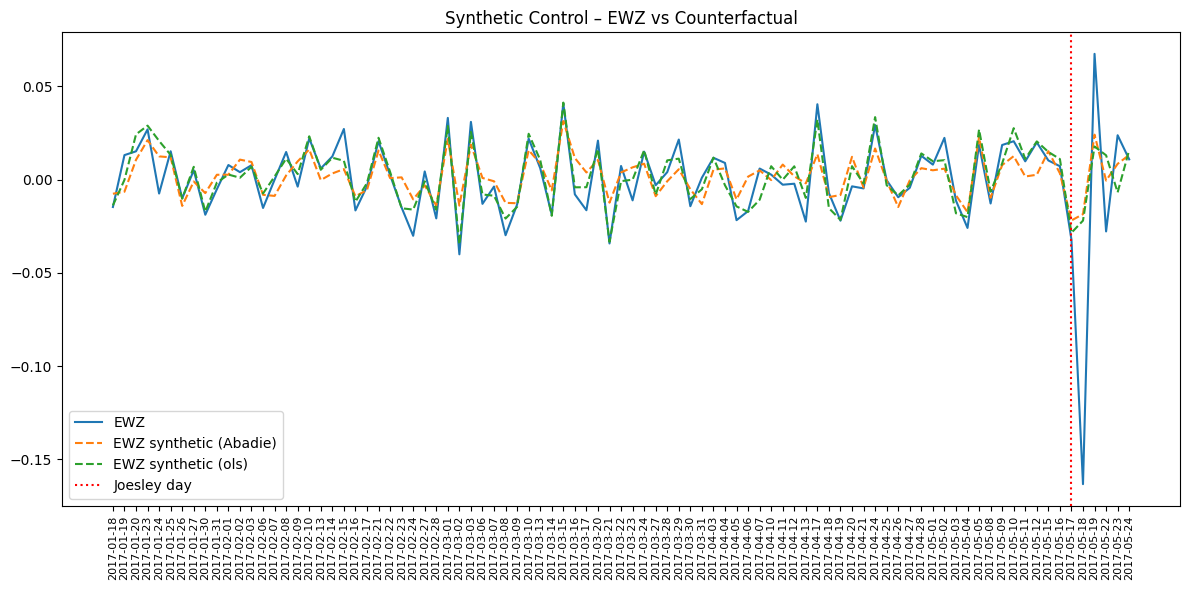

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, treated.values, label="EWZ")
plt.plot(df_norm.index, EWZ_synth_abadie, label="EWZ synthetic (Abadie)", linestyle="--")
plt.plot(df_norm.index, EWZ_synth_ols, label="EWZ synthetic (ols)", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Joesley day")

plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.title("Synthetic Control – EWZ vs Counterfactual")
plt.tight_layout()
plt.show()


---

https://doi.org/10.1080/13504851.2022.2140750